# Read data from numerical Simulation

The raw data are from the numerical Simulation by Seta and Federrath 2022 (https://ui.adsabs.harvard.edu/abs/2022MNRAS.514..957S/abstract)

# Install packages

In [1]:
# ! pip install astroML

In [2]:
# !pip install torch-lr-finder

In [3]:
! pip install spectral-cube

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.6/218.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.6/399.6 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.1/74.1 kB 5.0 MB/s eta 0:00:00


# Connect and authorize google drive

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


In [5]:
%cd /content/gdrive/My Drive/Colab Notebooks/ML_HI/
!ls

/content/gdrive/My Drive/Colab Notebooks/ML_HI
autoencoder_compress.png		lightning_logs
autoencoder.h5				MCMC
autoencoder_no_compress.png		MCMC_
best_rs_1.pickle			MLPClassifier_MLPRegressor.ipynb
best_rs_2.pickle			MLPRegressor.ipynb
best_rs_3.pickle			model.png
best_rs_chan400_1.pickle		MRF
catalogged_verification.fits		pytorch
checkpoint				random_weights.h5
CNN					rhi_zea.fits
conv_autoencoder.h5			RL
conv_encoder.h5				spec64k.npz
data					tigress
encoder_compress.png			training_data_kok14_galfa.pickle
encoder.h5				transforms
fcnm_zea.fits				Untitled.ipynb
figures					VAE_decoder.h5
Find_GNOMES_sightlines.ipynb		VAE_encoder.h5
GASS_HI_SMC_foreground_cube_414chan.nc	VAE.h5
GNOMES_vs_GALFA_spectra.ipynb		vae_mlp_decoder.png
libs


In [6]:
! pwd

/content/gdrive/My Drive/Colab Notebooks/ML_HI


# Paths

In [7]:
import sys, os
base_path = os.getcwd()

data_path  = os.path.join(base_path, 'data')
vae_path = os.path.join(base_path, 'vae')
seta_data_path = os.path.join(data_path, 'seta', '')

print(base_path)
print(data_path)

/content/gdrive/My Drive/Colab Notebooks/ML_HI
/content/gdrive/My Drive/Colab Notebooks/ML_HI/data


In [8]:
training_data_file = 'Tb_mpism_comp_1200_thick.fits'
rhi_file = 'R_map_mpism_comp_1200.fits'
fcnm_file = 'fcnm_map_mpism_comp_1200_Tcut_500K.fits'

training_data_fits_file = os.path.join(seta_data_path, training_data_file)
training_fcnm_file = os.path.join(seta_data_path, fcnm_file)
training_rhi_file = os.path.join(seta_data_path, rhi_file)

print(training_data_fits_file)
print(training_fcnm_file)
print(training_rhi_file)

/content/gdrive/My Drive/Colab Notebooks/ML_HI/data/seta/Tb_mpism_comp_1200_thick.fits
/content/gdrive/My Drive/Colab Notebooks/ML_HI/data/seta/fcnm_map_mpism_comp_1200_Tcut_500K.fits
/content/gdrive/My Drive/Colab Notebooks/ML_HI/data/seta/R_map_mpism_comp_1200.fits


# Libraries

In [9]:
sys.path.insert(1, data_path)

from __future__ import print_function, division
from astropy.io          import fits
from astropy             import units as u
from astropy.coordinates import SkyCoord

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy import ndimage

import glob
import pickle

In [10]:
from astropy.wcs import WCS
from spectral_cube import SpectralCube

# Read training dataset

Training set is a datacube with a size of (101, 512, 512) includes (512x512) spectra (spectral data: signal strength T_b as a function of 101 wavelength channels) and their ground-truth cold atomic hydrogen gas fraction (FCNM) and opacity correction factor (R). The training dataset was obtained from a simulation.

FCNM range: from ~0. to (less than) 1.
R range: >= 1

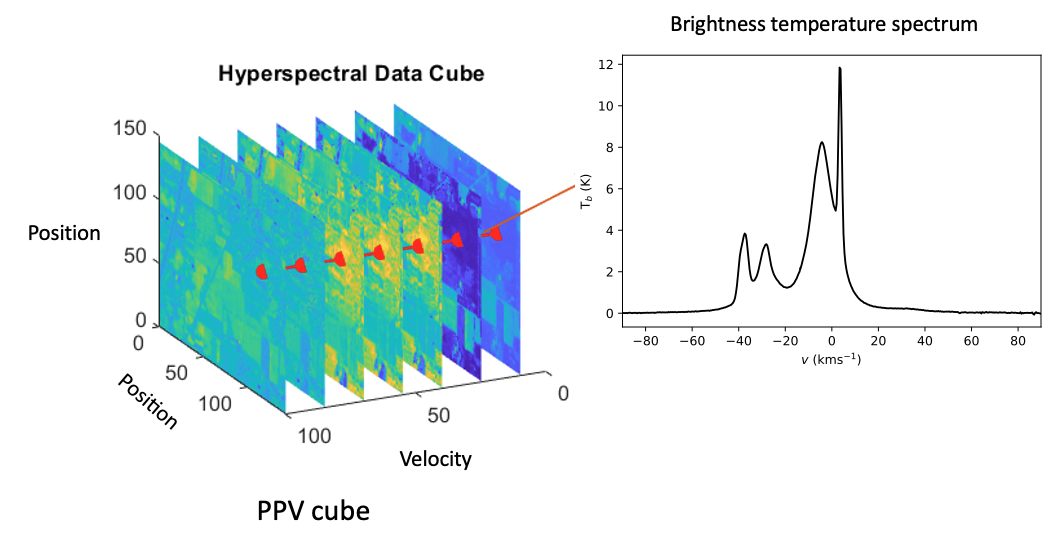

**Note:** Atomic Hydrogen Gas = HI

In [11]:
data, hdr = fits.getdata(training_data_fits_file, header=True)
print(data.shape)

(101, 512, 512)


Position X : 512 bins

Position Y : 512 bins

Velocity Z : 101 channels (in radio astronomy, wavelength [m]/frequency [Hz] is often converted into velocity [VLSR: km/s or m/s].)

In [12]:
# Velocity defined for the HI radiative transfer
vmin = -40 #km.s-1                                                               
vmax = 40 #km.s-1                                                                
dv = 0.8 #km.s-1

In [13]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  512                                                  
NAXIS2  =                  512                                                  
NAXIS3  =                  101                                                  
CTYPE3  = 'v [km.s-1]'                                                          
CRVAL3  =   -8.000000000000114                                                  
CDELT3  =                  0.8                                                  
CRPIX3  =                   40                                                  
BUNIT   = 'K       '                                                            
COMMENT Tb                                                                      

# Read the data cube with noise

Position-Position-Velocity (PPV) emission cubes with realistic noise (1K) and beam (30'') for a simulation located at 400pc.

In [14]:
#Noise level and beam size
noise = 1. #K
beam = 1.45 #pix ASKAP at 400pc with Saury resolution

In [15]:
training_data_with_noise = 'Tb_mpism_comp_1200_thick' + '_noise_' + str(noise) + '_K_beam_' + str(beam) + '_pix.fits'
training_data_fits_outfile_with_noise = os.path.join(seta_data_path, training_data_with_noise)
print(training_data_fits_outfile_with_noise)

/content/gdrive/My Drive/Colab Notebooks/ML_HI/data/seta/Tb_mpism_comp_1200_thick_noise_1.0_K_beam_1.45_pix.fits


In [17]:
data, hdr = fits.getdata(training_data_fits_outfile_with_noise, header=True)
print(data.shape)

(101, 512, 512)


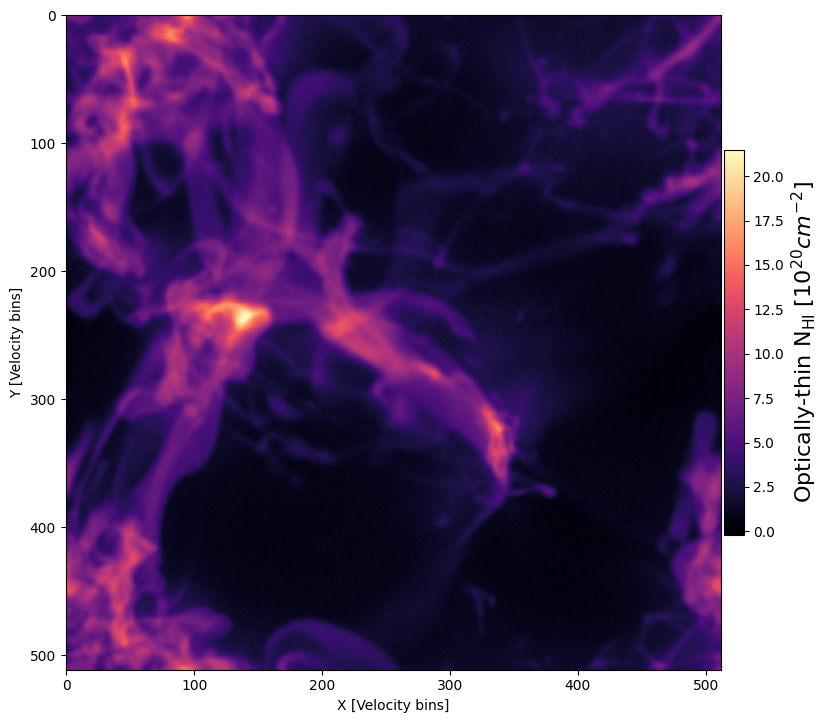

In [18]:
WHI = np.sum(data, axis=0)
NHI_thin = 1.8224 * 1.e-2 * WHI * dv # In unit of 10^20 cm-2

plt.figure(figsize=(10,10))
plt.imshow(NHI_thin, cmap='magma')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('Optically-thin N$_\mathrm{HI}$ [10$^{20} cm^{-2}$]', size=16)

plt.title('')
plt.xlabel('X [Velocity bins]')
plt.ylabel('Y [Velocity bins]')
plt.show()

# Cold HI gas fraction

Each spectrum at (Xi, Yi) has a corresponding ground-truth $F_{CNM}$ at the same sky pixel (Xi, Yi).

## Ground truth

In [20]:
# Ground-truth
fcnm_data, hdr = fits.getdata(training_fcnm_file, header=True)
print(fcnm_data.shape)

(512, 512)


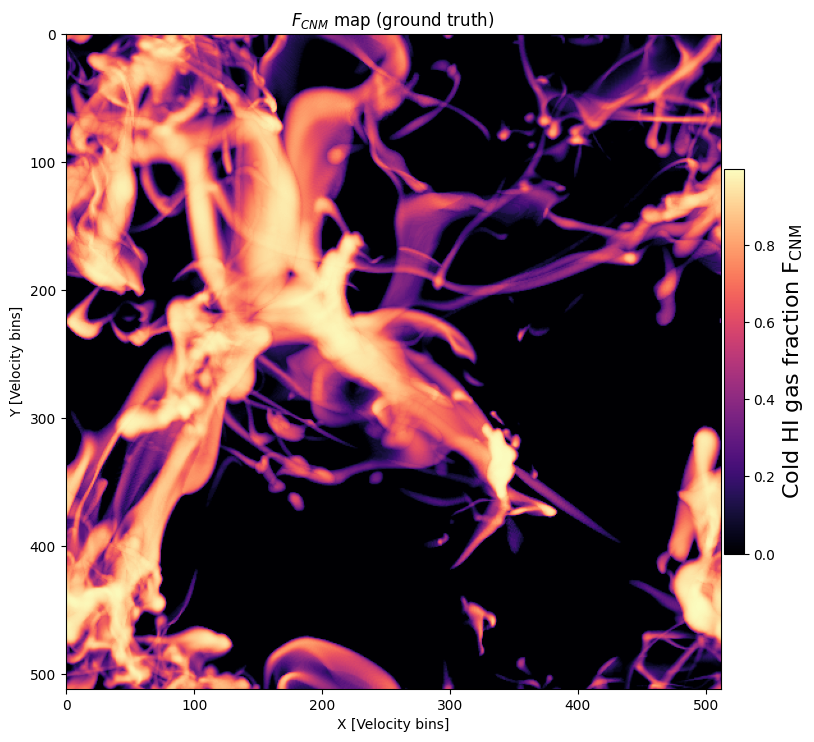

In [23]:
plt.figure(figsize=(10,10))
plt.imshow(fcnm_data, cmap='magma')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('Cold HI gas fraction F$_\mathrm{CNM}$', size=16)

plt.title('$F_{CNM}$ map (ground truth)')
plt.xlabel('X [Velocity bins]')
plt.ylabel('Y [Velocity bins]')
plt.show()

## Read smoothed data (with noise): Just to estimate the uncertainty

In [24]:
# Noise level and beam size
noise = 1. #K
beam = 1.45 # pix - ASKAP at 400pc with Saury resolution

training_fcnm_outfile_with_noise = 'fcnm_map_mpism_comp_1200_Tcut_500K' + '_noise_' + str(noise) + '_K_beam_' + str(beam) + '_pix.fits'
training_fcnm_fits_outfile_with_noise = os.path.join(seta_data_path, training_fcnm_outfile_with_noise)
print(training_fcnm_fits_outfile_with_noise)

/content/gdrive/My Drive/Colab Notebooks/ML_HI/data/seta/fcnm_map_mpism_comp_1200_Tcut_500K_noise_1.0_K_beam_1.45_pix.fits


In [26]:
fcnm_noise_data, hdr = fits.getdata(training_fcnm_fits_outfile_with_noise, header=True)
print(fcnm_noise_data.shape)

(512, 512)


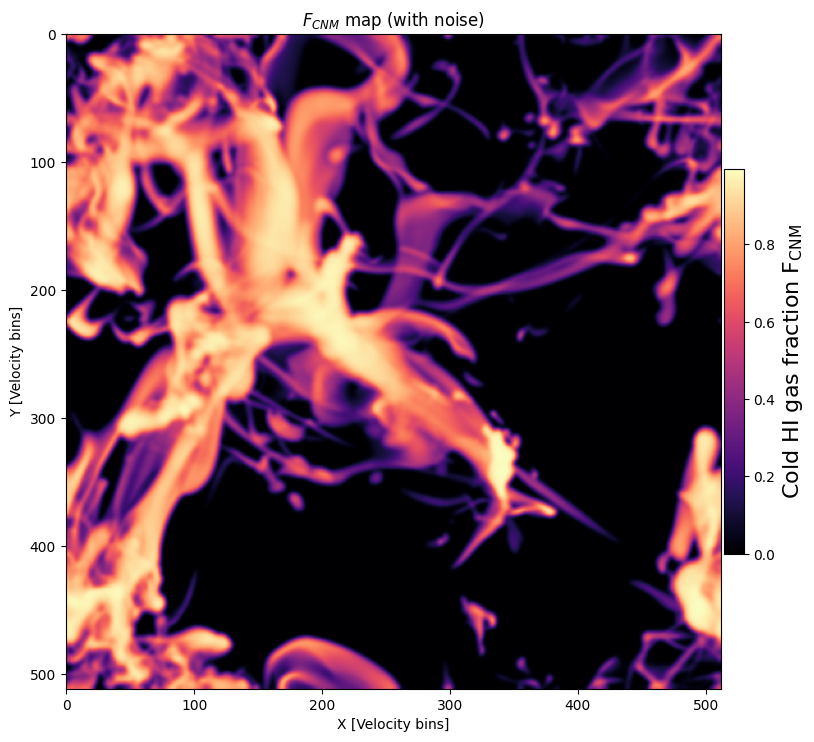

In [28]:
plt.figure(figsize=(10,10))
plt.imshow(fcnm_noise_data, cmap='magma')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('Cold HI gas fraction F$_\mathrm{CNM}$', size=16)

plt.title('$F_{CNM}$ map (with noise)')
plt.xlabel('X [Velocity bins]')
plt.ylabel('Y [Velocity bins]')
plt.show()

# Opacity correction factor

Each spectrum at (Xi, Yi) has a corresponding ground-truth $R_{HI}$ at the same sky pixel (Xi, Yi).

## Ground truth

In [29]:
rhi_data, hdr = fits.getdata(training_rhi_file, header=True)
print(rhi_data.shape)

(512, 512)


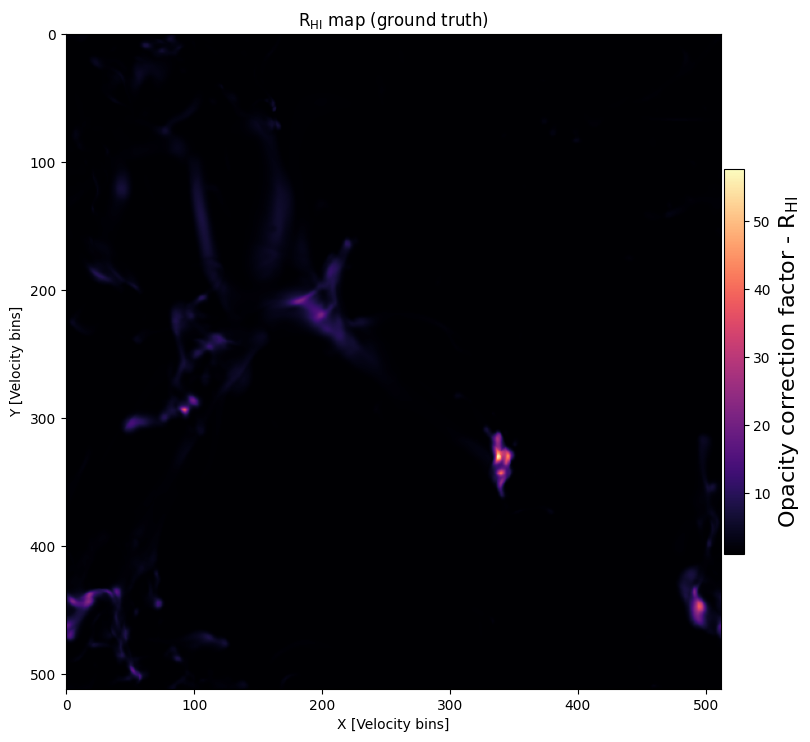

In [30]:
plt.figure(figsize=(10,10))
plt.imshow(rhi_data, cmap='magma')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('Opacity correction factor - R$_\mathrm{HI}$', size=16)

plt.title(r'R$_\mathrm{HI}$ map (ground truth)')
plt.xlabel('X [Velocity bins]')
plt.ylabel('Y [Velocity bins]')
plt.show()

## Read smoothed data (with noise): only to estimate the uncetainty

In [31]:
# Noise level and beam size
noise = 1. #K
beam = 1.45 # pix - ASKAP at 400pc with Saury resolution

training_rhi_outfile_with_noise = 'R_map_mpism_comp_1200' + '_noise_' + str(noise) + '_K_beam_' + str(beam) + '_pix.fits'
training_rhi_fits_outfile_with_noise = os.path.join(seta_data_path, training_rhi_outfile_with_noise)
print(training_rhi_fits_outfile_with_noise)

/content/gdrive/My Drive/Colab Notebooks/ML_HI/data/seta/R_map_mpism_comp_1200_noise_1.0_K_beam_1.45_pix.fits


In [32]:
rhi_noise_data, hdr = fits.getdata(training_rhi_fits_outfile_with_noise, header=True)
print(rhi_noise_data.shape)

(512, 512)


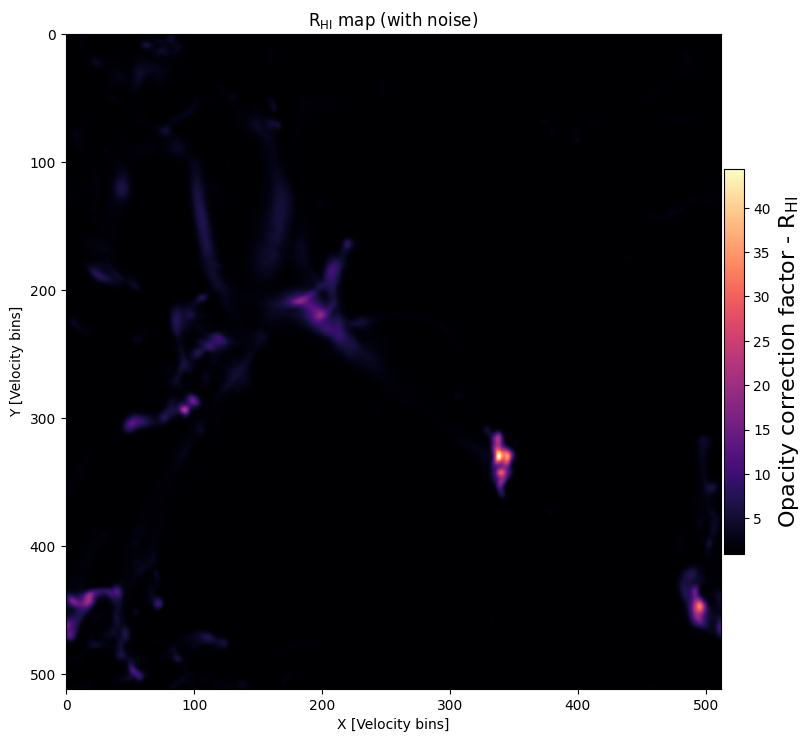

In [33]:
plt.figure(figsize=(10,10))
plt.imshow(rhi_noise_data, cmap='magma')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('Opacity correction factor - R$_\mathrm{HI}$', size=16)

plt.title(r'R$_\mathrm{HI}$ map (with noise)')
plt.xlabel('X [Velocity bins]')
plt.ylabel('Y [Velocity bins]')
plt.show()

# Plot a few spectra

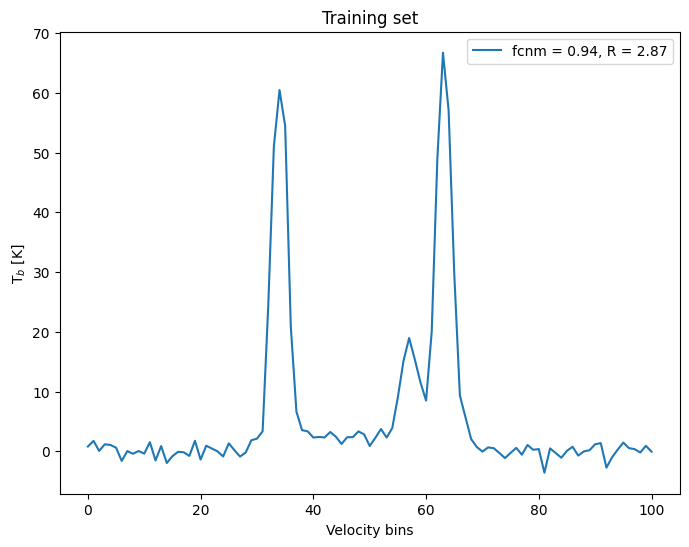

In [35]:
xid, yid = 100, 100
fcnm_val = fcnm_data[xid, yid]
rhi_val = rhi_data[xid, yid]

# Spectrum in training set
plt.figure(figsize=(8,6))
plt.plot(data[:, yid, xid], label='fcnm = %3.2f, R = %3.2f' % (fcnm_val, rhi_val))

plt.title('Training set')
plt.xlabel('Velocity bins')
plt.ylabel('T$_b$ [K]')

plt.legend()

plt.show()

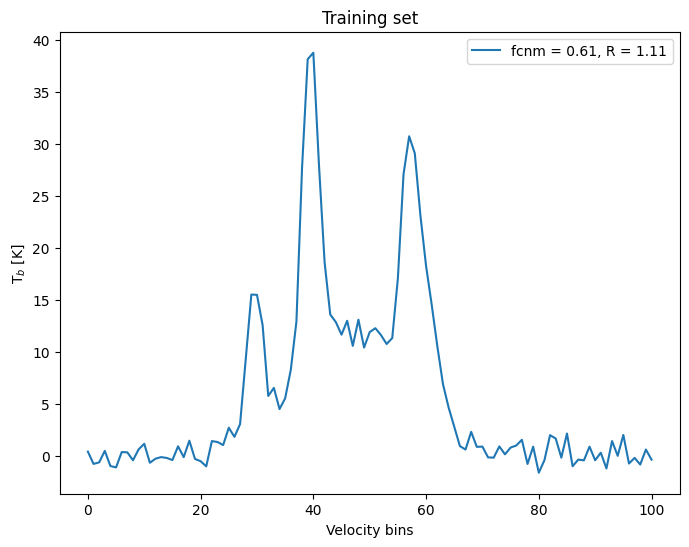

In [36]:
# Spectrum in training set
xid, yid = 100, 20
fcnm_val = fcnm_data[xid, yid]
rhi_val = rhi_data[xid, yid]

plt.figure(figsize=(8,6))
plt.plot(data[:, yid, xid], label='fcnm = %3.2f, R = %3.2f' % (fcnm_val, rhi_val))

plt.title('Training set')
plt.xlabel('Velocity bins')
plt.ylabel('T$_b$ [K]')

plt.legend()

plt.show()

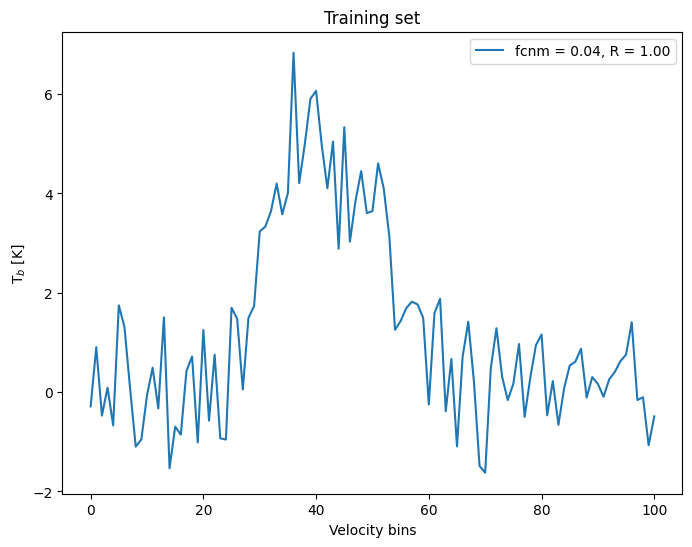

In [37]:
# Spectrum in training set
xid, yid = 200, 20
fcnm_val = fcnm_data[xid, yid]
rhi_val = rhi_data[xid, yid]

plt.figure(figsize=(8,6))
plt.plot(data[:, yid, xid], label='fcnm = %3.2f, R = %3.2f' % (fcnm_val, rhi_val))

plt.title('Training set')
plt.xlabel('Velocity bins')
plt.ylabel('T$_b$ [K]')

plt.legend()

plt.show()

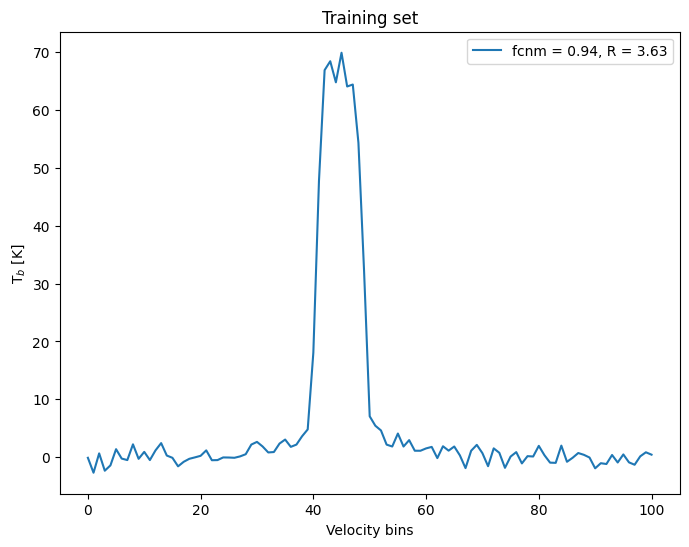

In [38]:
# Spectrum in training set
xid, yid = 200, 200
fcnm_val = fcnm_data[xid, yid]
rhi_val = rhi_data[xid, yid]

plt.figure(figsize=(8,6))
plt.plot(data[:, yid, xid], label='fcnm = %3.2f, R = %3.2f' % (fcnm_val, rhi_val))

plt.title('Training set')
plt.xlabel('Velocity bins')
plt.ylabel('T$_b$ [K]')

plt.legend()

plt.show()

# Histogram of FCNM and R

**Note:** Atomic Hydrogen Gas = HI

In [39]:
FCNM = fcnm_data.ravel()
R    = rhi_noise_data.ravel()

In [40]:
FCNM.shape

(262144,)

In [ ]:
# stats_series = pd.DataFrame(FCNM).describe()
# series_index = stats_series.index.to_list()
# series_values = stats_series.values.flatten()
# print('FCNM:')
# stats_series

In [ ]:
# stats_series = pd.DataFrame(R).describe()
# series_index = stats_series.index.to_list()
# series_values = stats_series.values.flatten()
# print('R:')
# stats_series

## Cold HI gas fraction: FCNM

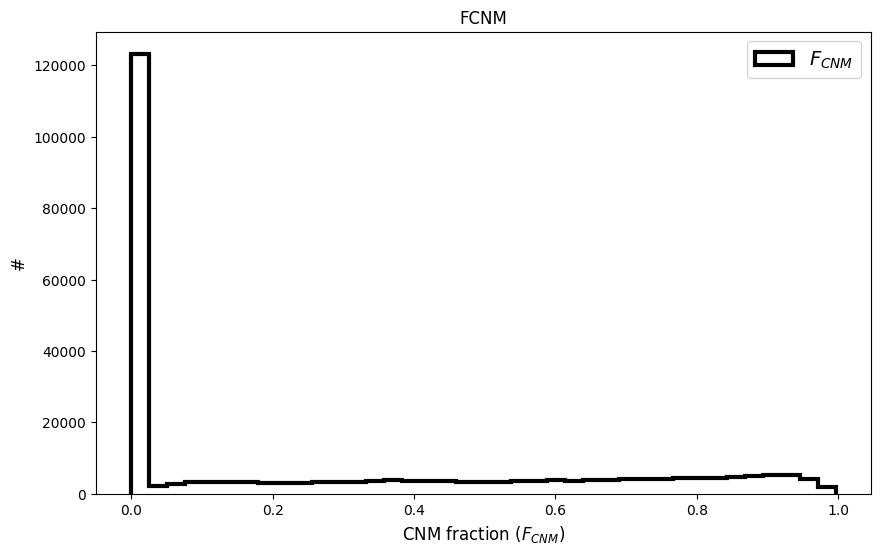

In [41]:
# Plot histograms
plt.figure(figsize=(10, 6))

plt.hist(FCNM, bins=np.linspace(0., FCNM.max(), 40),
         density=False, color='k', histtype='step',
         alpha=1., ls='-', lw=3,
         label='$F_{CNM}$')

plt.title(f'FCNM')
plt.xlabel(r'CNM fraction ($F_{CNM}$)', fontsize=12)
plt.ylabel(r'#', fontsize=12)
# plt.yscale('log')

plt.legend(loc='upper right', fontsize=14)
plt.show()

## HI Opacity correction  Factor : R

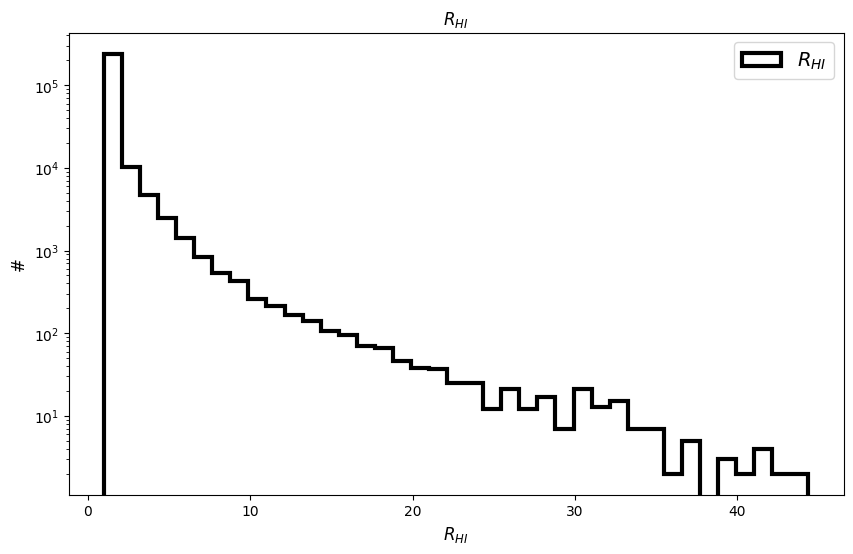

In [42]:
# Plot histograms
plt.figure(figsize=(10, 6))

plt.hist(R, bins=np.linspace(1., R.max(), 40),
         density=False, color='k', histtype='step',
         alpha=1., ls='-', lw=3,
         label='$R_{HI}$')

plt.title('$R_{HI}$')
plt.xlabel(r'$R_{HI}$', fontsize=12)
plt.ylabel(r'#', fontsize=12)
plt.yscale('log')

plt.legend(loc='upper right', fontsize=14)
plt.show()